## Download Data

You can access the AHN data (Actueel Hoogtebestand Nederland) trough their [website](https://www.ahn.nl/ahn-4) and de [ESRI Explorer](https://hub.arcgis.com/maps/esrinl-content::ahn4-download-kaartbladen-1/explore). To download, simply click on one of the tiles and select the data you want to download. In this case we are going to work with a **DTM 5m** resolution.

## Clip the area

#### Import the necesary libraries



In [38]:
import pickle
import trimesh as tm
import math
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from matplotlib import cm
from open3d.web_visualizer import draw
# o3d.visualization.webrtc_server.enable_webrtc()


In [39]:
## load result from previous notebook using pickle
with open('mesh.pkl','rb') as file:
    mesh = pickle.load(file)

mesh.show()

In [40]:
## Use mathematical spherical coordinates
# Set the number of azimuth (theta) and elevation (phi) angles
T = 180  # Theta counter - Azimuth Angles
K = 45   # Phi counter - Elevation Angles

# Set the size of the dome
r = 10

# Initialize a list to store hemisphere vertices
hemisphereVertices = []

# Loop through azimuth and elevation angles
for t in range(T):
    for k in range(K):
        # Calculate spherical coordinates
        theta = (float(t / T)) * math.pi * 2
        phi = (float(k / K)) * math.pi / 2
        
        # Convert spherical coordinates to Cartesian coordinates
        x = r * math.sin(phi) * math.cos(theta)
        y = r * math.sin(phi) * math.sin(theta)
        z = r * math.cos(phi)
        
        # Create a 3D vertex using Cartesian coordinates
        hSVertex = [x, y, z]

        # Append the vertex to the list
        hemisphereVertices.append(hSVertex)

# The list hemisphereVertices now contains the 3D coordinates of the vertices in the hemisphere
# hemisphereVertices


In [41]:
# Create an Open3D PointCloud object
domePC = o3d.geometry.PointCloud()

# Set the points of the PointCloud to the hemisphereVertices
domePC.points = o3d.utility.Vector3dVector(hemisphereVertices)

# Visualize the PointCloud using Open3D
o3d.visualization.draw_geometries([domePC])

### Now lets do it with NP Meshgrids

In [69]:
# Set the number of theta (azimuth) and phi (elevation) angles
nt, nk = (T, K)

# Generate arrays of theta and phi values
thetaArray = np.linspace(0, 2 * np.pi, nt)
phiArray = np.linspace(0, np.pi / 2, nk)

# Create 2D grids for theta and phi
thetaGrid, phiGrid = np.meshgrid(thetaArray, phiArray)

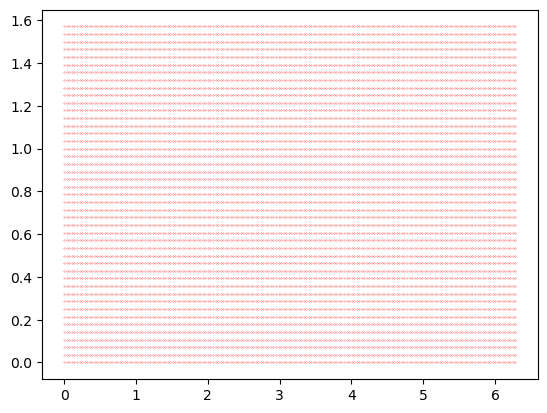

In [43]:
# Visualize the meshgrid in a 2D space
plt.plot(thetaGrid, phiGrid, marker='o', color='r', linestyle='none', markersize=0.2)
plt.show()

In [70]:
# Define a function to convert spherical coordinates to Cartesian coordinates
def Spherical2Cartesian(r, theta, phi):
    # Calculate Cartesian coordinates using spherical coordinates
    x = r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)
    
    # Return the Cartesian coordinates as a NumPy array
    return np.array([x, y, z])

# Convert spherical coordinates to Cartesian coordinates for the entire grid
CartesianPoints = Spherical2Cartesian(r, thetaGrid, phiGrid)

# Reshape and transpose the Cartesian points
CartesianPointsR = CartesianPoints.reshape(3, -1).T

# Transpose the original Cartesian points
CartesianPointsT = CartesianPoints.T

# Display the shape of the transposed Cartesian points
CartesianPointsT.shape



(180, 45, 3)

In [71]:
#Visualize Points in 3D
domeMesh = o3d.geometry.PointCloud()
domeMesh.points = o3d.utility.Vector3dVector(CartesianPointsR)
o3d.visualization.draw_geometries([domeMesh])

## Let's Calculate the Sky View Factor for the City Center
### Create Rays for all points in dome

In [72]:
## http://www.open3d.org/docs/latest/tutorial/geometry/ray_casting.html

[0.38397244 0.38397244 0.38397244 0.38397244 0.38397244 0.38397244
 0.38397244 0.38397244 0.34906585 0.34906585 0.34906585 0.34906585
 0.34906585 0.34906585 0.31415927 0.31415927 0.31415927 0.31415927
 0.27925268 0.27925268 0.27925268 0.27925268 0.2443461  0.20943951
 0.17453293 0.13962634 0.06981317 0.03490659 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0

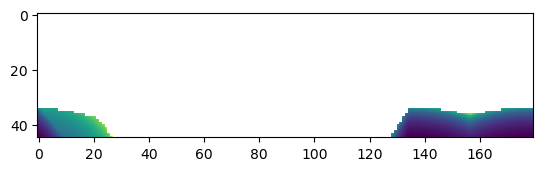

In [133]:
# Define a vertex as a point in the mesh with an added height
vertex = np.array(mesh.vertices[234] + [0, 0, 1])

# Broadcast the vertex to create ray origins for each point in the Cartesian grid
rayOrigins = np.broadcast_to(vertex, CartesianPointsT.shape)

# Create ray directions using CartesianPointsT
rayDirections = CartesianPointsT

# Concatenate ray origins and directions to create a 3D array of rays
raysOD = np.concatenate((rayOrigins, rayDirections), axis=2)

# Read a triangle mesh from an OBJ file
o3dMesh = o3d.io.read_triangle_mesh('../Results/mesh.obj')

# Convert the Open3D mesh to the new TriangleMesh data structure
o3dMeshLegacy = o3d.t.geometry.TriangleMesh.from_legacy(o3dMesh)

# Create a RaycastingScene and add triangles from the mesh
scene = o3d.t.geometry.RaycastingScene()
scene.add_triangles(o3dMeshLegacy)

# Create an Open3D tensor from the raysOD array
o3dRayGrid = o3d.core.Tensor(raysOD, dtype=o3d.core.Dtype.Float32)

# Cast rays into the scene and retrieve hit information
ans = scene.cast_rays(o3dRayGrid)

# Extract hit distances (depth) from the result and create a transposed image
SVimage = ans['t_hit'].numpy().T

# Identify valid hit points (non-infinite depth)
gamma=np.argmax(np.ma.masked_where(SVimage==np.inf,SVimage)!=np.inf,axis=0)#gamma = np.where(SVimage!=np.inf,SVimage,K-1)#np.where(SVimage != np.inf)[0]#[0][:]# TODO: gamma angles need to be translated to radians, right now they are sample numbers
#(float(k / K)) * math.pi / 2 TODO: we should ensure that we get 180 gamma angles but cuurently we get 172 angles!
#SVF = (1 - np.sum((np.sin(gamma)) / K, axis=0)) / (2 * np.pi)

# Display the SVF values and visualize the hit distances (depth) as an image
#print(SVF)
plt.imshow(SVimage)


# gamma=(gamma/K)*np.pi/2

gamma=np.where(gamma==0,K,gamma)

gamma=(gamma/K)*np.pi/2
gamma=(np.pi/2)-gamma

print(gamma)
print(gamma.shape)
#print(SVimage)
SVF = (1 - np.sum((np.sin(gamma)) / T, axis=0))#/(2 * np.pi)
print(SVF)
# print(gamma.shape)
# print(SVimage.shape)

In [50]:
# Find indices of valid hit points (non-infinite depth) in SVimage
gamma = np.where(SVimage != np.inf)[0][:]

# Calculate the Solid View Factor (SVF) using the valid hit points
SVF = (1 - np.sum((np.sin(gamma)) / K, axis=0)) / (2 * np.pi)

# Display the Solid View Factor (SVF) values
SVF


0.35394020876080584

In [23]:
# Function to create a sky dome using spherical coordinates
def CreateSkyDome(Tthetas, Kphis):
    # Generate arrays of theta and phi values for the sky dome
    nt, nk = (Tthetas, Kphis)
    thetaArray = np.linspace(0, 2 * np.pi, nt)
    phiArray = np.linspace(0, np.pi / 2, nk)
    # Create 2D grids for theta and phi
    thetaGrid, phiGrid = np.meshgrid(thetaArray, phiArray)
    # Convert spherical coordinates to Cartesian coordinates
    CartesianPoints = Spherical2Cartesian(r, thetaGrid, phiGrid)
    CartesianPointsT = CartesianPoints.T
    return CartesianPointsT

# Function to convert spherical coordinates to Cartesian coordinates
def Spherical2Cartesian(r, theta, phi):
    # Calculate Cartesian coordinates using spherical coordinates
    x = r * np.sin(phi) * np.cos(theta)
    y = r * np.sin(phi) * np.sin(theta)
    z = r * np.cos(phi)
    return np.array([x, y, z])

# Function to calculate Solid View Factor (SVF) for a given vertex and scene mesh
def CalculateSVF(vertex, sceneMesh, Kphis, Tthetas):
    # Create a sky dome using spherical coordinates
    CartesianPointsT = CreateSkyDome(Tthetas, Kphis)
    # Broadcast vertex and create ray origins for each point in the sky dome
    rayOrigins = np.broadcast_to(vertex + [0, 0, 1], CartesianPointsT.shape)
    # Use the sky dome points as ray directions
    rayDirections = CartesianPointsT
    # Concatenate ray origins and directions to create a 3D array of rays
    raysOD = np.concatenate((rayOrigins, rayDirections), axis=2)
    # Convert the scene mesh to the new TriangleMesh data structure
    o3dMeshLegacy = o3d.t.geometry.TriangleMesh.from_legacy(sceneMesh)
    # Create a RaycastingScene and add triangles from the mesh
    scene = o3d.t.geometry.RaycastingScene()
    scene.add_triangles(o3dMeshLegacy)
    # Create an Open3D tensor from the raysOD array
    o3dRayGrid = o3d.core.Tensor(raysOD, dtype=o3d.core.Dtype.Float32)
    # Cast rays into the scene and retrieve hit information
    ans = scene.cast_rays(o3dRayGrid)
    # Extract hit distances (depth) from the result and create a transposed image
    SVimage = ans['t_hit'].numpy().T
    # Identify valid hit points (non-infinite depth)
    gamma = np.where(SVimage != np.inf)[0][:]
    # Calculate Solid View Factor (SVF) using the valid hit points
    SVF = (1 - np.sum((np.sin(gamma)) / Kphis, axis=0)) / (2 * np.pi)

    return SVF


In [51]:
# Initialize a list to store Solid View Factor (SVF) values for each vertex
SVFValues = []

# Iterate through vertices of the Open3D mesh
for v in o3dMesh.vertices:
    # Calculate SVF for each vertex using the CalculateSVF function
    SVF = CalculateSVF(v, o3dMesh, 30, 10)
    
    # Append the calculated SVF to the SVFValues list
    SVFValues.append(SVF)
    
    # Uncomment the following line to print each vertex
    # print(v)

# Display the list of SVF values for each vertex
SVFValues

[0.1450170182435787,
 0.1450170182435787,
 0.14749678478776002,
 0.14749678478776002,
 0.14749678478776002,
 0.14749678478776002,
 0.15647546213907335,
 0.16045957322316287,
 0.15727058543156267,
 0.16045957322316287,
 0.15727058543156267,
 0.1565693774475002,
 0.15736450073998953,
 0.1610587161231569,
 0.15736450073998953,
 0.15218152408724225,
 0.15297664737973155,
 0.15218152408724225,
 0.15218152408724225,
 0.14249487412553746,
 0.14488873862464835,
 0.1528569607928274,
 0.1528569607928274,
 0.16815807710370553,
 0.16305770500007952,
 0.17125978382323873,
 0.17121282616902533,
 0.16436001554366828,
 0.15953166508332675,
 0.16973240929057887,
 0.16973240929057887,
 0.1693372742161134,
 0.15953166508332675,
 0.16628252515079361,
 0.16973240929057887,
 0.1693372742161134,
 0.16588739007632813,
 0.14748823943045025,
 0.16588739007632813,
 0.14748823943045025,
 0.16243750593654288,
 0.14223290418638257,
 0.15443929596836947,
 0.13709533137943875,
 0.14938925628016725,
 0.131554583418009

In [52]:
# Check the maximum and minimum values

print(np.min(SVFValues,axis=0))
print(np.max(SVFValues,axis=0))

0.09567586424317337
0.19148741442905787


### Visualazing the SVF

In [53]:
# Get the 'viridis' colormap with 256 colors
viridis = cm.get_cmap('viridis', 256)

# Generate colors from the 'viridis' colormap
colors = viridis(np.linspace(0, 1, 256))

# Normalize SVF values to the range [0, 1]
normalizedSVF = (SVFValues - np.min(SVFValues)) / (np.max(SVFValues) - np.min(SVFValues))

# Map normalized SVF values to colors using the 'viridis' colormap
SVFColors = viridis(normalizedSVF)

# Create an Open3D tensor from the SVFColors array
SVFColorsTensor = o3d.core.Tensor(SVFColors, dtype=o3d.core.Dtype.Float32)

# Display the SVFColors array
SVFColors
#print(type(SVFColors))

C:\Users\NourianP\AppData\Local\Temp\ipykernel_32536\4207292366.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', 256)


array([[0.124395, 0.578002, 0.548287, 1.      ],
       [0.124395, 0.578002, 0.548287, 1.      ],
       [0.119738, 0.603785, 0.5414  , 1.      ],
       ...,
       [0.126326, 0.644107, 0.525311, 1.      ],
       [0.162016, 0.687316, 0.499129, 1.      ],
       [0.226397, 0.728888, 0.462789, 1.      ]])

In [55]:
# Assign the SVFColorsTensor to the vertex colors of the Open3D TriangleMesh
o3dMeshLegacy.vertex.colors = SVFColorsTensor


In [56]:
# Convert the vertex positions of the Open3D TriangleMesh to a Vector3dVector
meshVertices = o3d.utility.Vector3dVector(np.array(o3dMeshLegacy.vertex.positions.numpy()))

# Convert the triangle indices of the Open3D TriangleMesh to a Vector3iVector
meshTriangles = o3d.utility.Vector3iVector(np.array(o3dMeshLegacy.triangle.indices.numpy()))


In [57]:
# Create a new TriangleMesh using the converted vertex positions and triangle indices
meshP = o3d.geometry.TriangleMesh()
meshP.vertices = meshVertices
meshP.triangles = meshTriangles

# Display the new TriangleMesh
meshP


TriangleMesh with 6225 points and 12136 triangles.

In [59]:
# delete alpha channel from the colors
SVFColorsRGB = np.delete(SVFColors,3,axis=1)
SVFColorsRGB

array([[0.124395, 0.578002, 0.548287],
       [0.124395, 0.578002, 0.548287],
       [0.119738, 0.603785, 0.5414  ],
       ...,
       [0.126326, 0.644107, 0.525311],
       [0.162016, 0.687316, 0.499129],
       [0.226397, 0.728888, 0.462789]])

In [60]:
# Convert SVFColorsRGB to an Open3D Vector3dVector
SVFColorsVector = o3d.utility.Vector3dVector(SVFColorsRGB)

# Assign the SVFColorsVector to the vertex colors of the new Mesh (meshP)
meshP.vertex_colors = SVFColorsVector

In [61]:
# Visualize the geometry with Colors
o3d.visualization.draw_geometries([meshP])

### With Trimesh

Try it yourself. Look into the documentation and finish the following cells of code.

In [62]:
# vertex = np.array([0,0,0])

rayDirections=(CartesianPointsT).reshape(-1,3)
rayOrigins = np.broadcast_to(vertex, rayDirections.shape)
# for t in range(T):
#     for k in range(K):
#         hsPoint = CartesianPointsT[t,k,:]
#         ray = (vertex,hsPoint)
hitLocations,indexRay, indexTriangle= mesh.ray.intersects_location(ray_origins=rayOrigins,ray_directions=rayDirections)

hitLocations.shape,indexRay.shape
# rayDirections.shape




KeyboardInterrupt: 

In [34]:
indexTriangle, indexRay = tm.ray.ray_triangle.RayMeshIntersector(mesh).intersects_id(ray_origins=rayOrigins,ray_directions=rayDirections,multiple_hits=False,return_loctaions=False)

indexTriangle, indexRay

indexRay.shape

(1590,)

In [35]:
unraveled = np.unravel_index(indexRay,CartesianPointsT.shape)

unraveled[0].shape, unraveled[1].shape, unraveled[2].shape
unraveledTheta = unraveled[0]